# <span id="toc">  Esercitazione 10 - Parallelizzazione </span>

[  Parallelizzazione ](#MPI)

[ 10.1 - Le capitali americane ](#ex-10.1)

### <span id="MPI">  Parallelizzazione </span>[^](#toc)

L'obiettivo di questa esercitazione è parallelizzare il codice dell'[esercitazione 9](../09-ok/my-09.ipynb) usando la libreria MPI (Message Passing Interface). Utilizzo il modello SPMD (Single Program Multiple Data), per cui ho un solo Main e ogni processo parallelo "vede" lo stesso eseguibile, ma lavora su dati differenti.

Parallelizzare l'esecuzione permette innanzitutto di **ridurre il tempo di calcolo**, ma anche di realizzare nuovi paradigmi computazionali: ne è un esempio il concetto di **migrazione** che usiamo in questa esercitazione.
Una volta che il codice è parallelizzato ogni nodo realizza **indipendentemente** la propria ricerca (per questo lo identifichiamo come un continente, nel parallelismo con le popolazioni che evolvono), ma ogni tanto facciamo in modo che i continenti scambino tra loro i migliori individui. Per la selezione dell'individuo da scambiare, ho scelto la stessa legge di potenza usata per la selezione degli individui da far mutare:
$$
h = \text{int}\left(N_{pop}\cdot\left(1-r^{p}\right)\right)-1
$$
dove però questa in questo caso ho posto $p=20$.

In questa esercitazione inoltre il problema da risolvere è più concreto (e più difficile): dobbiamo trovare il percorso minore che collega le $50$ capitali degli Stati Uniti.

Per realizzare la parallelizzazione ho dovuto modificare alcune funzioni di stampa (per tenere in ordine i risultati), mentre ho potuto affidarmi alla funzione `SetPrimesCouple` implementata in precedenza per impostare la coppia di numeri che inizializzano un RG: a ciascun core ho chiesto infatti di re-inizializzare il proprio RNG in base al proprio rank, chiamando `SetPrimesCouple(rank)`. Questo è ovviamente necessario per evitare che ciascun core esegua la stessa identica ricerca con la stessa identica sequenza di numeri casuali.

**Nota**: il criterio di *buon ordine* usato per costruire la libreria TSP mi ha premiato: sono state sufficienti poche e semplici modifiche alla libreria (oltre che al main), che continua ad essere perfettamente compatibile con l'esercitazione 9.


### Parametri utilizzati

Rispetto all'esercitazione 9, qui ho provato a regolare più finemente i parametri del modello in modo da selezionare la combinazione che mi forniva i risultati migliori.
Posto che ho tenuto uguali il numero di generazioni e di individui nella popolazione, questa volta ho numero di geni $50$ e probabilità di mutazione rispettivamente:  
0.1 (PairPermut)  
0.1 (Invertion)  
0.2 (Shift)  
0.2 (Shift2)  
0.4 (MPermut)  
0.6 (Crossover)

Ho infatti notato che aumentare la probabilità delle prime 4 mutazioni ha effetti negativi (probabilmente perchè una volta trovati dei percorsi *decenti*, esse tendono a rovinarli più che a migliorarli), mentre un piccolo aumento delle permutazioni a blocchi e crossover è efficace nella ricerca del best (probabilmente perchè una volta trovati i buoni percorsi, lo scambio di pezzetti di questi tende ad "affinare" la soluzione).

### Parallelo senza migrazioni (continenti indipendenti)

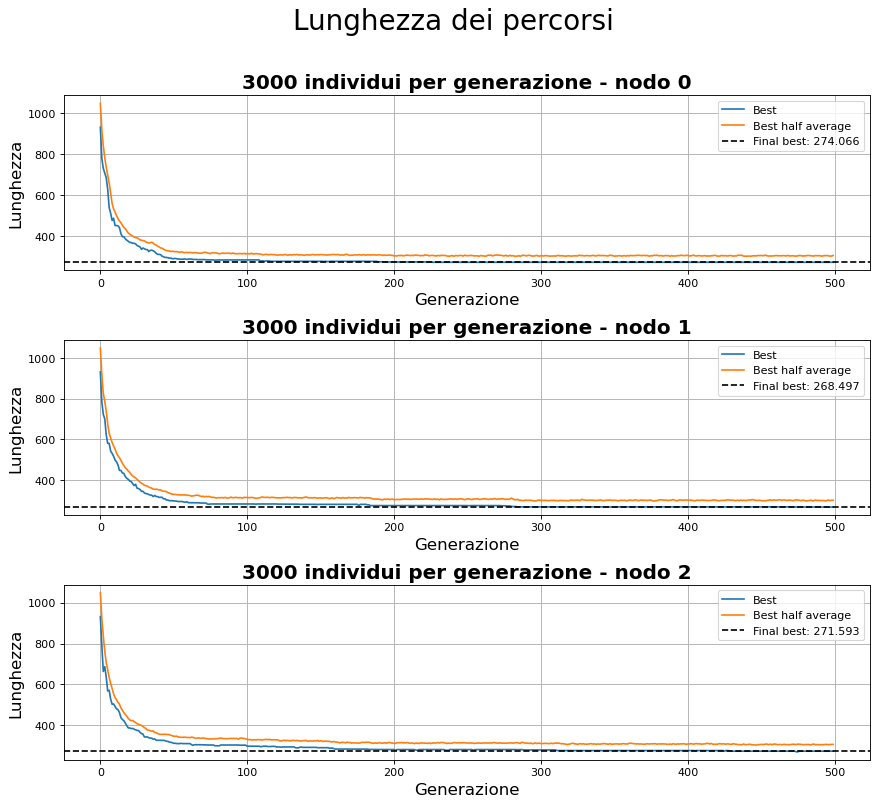

In [54]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

figure(figsize=(13, 11), dpi=80)
plt.suptitle("Lunghezza dei percorsi\n", fontsize = 25)

rank =["0", "1", "2"]

for i in range(0,3):
    # using rank[i] individuals per generation
    plt.subplot(3,1,i+1)
    gen,best = np.loadtxt("ex10/IndCont/bestLen/BL"+rank[i]+".out", usecols=(0,1), delimiter=' ', unpack='true')
    plt.plot(gen, best, marker = "", label = "Best") 
    bestave = np.loadtxt("ex10/IndCont/bestLen/BLAv"+rank[i]+".out", usecols=(1), delimiter=' ', unpack='true')
    plt.plot(gen, bestave, marker = "", label = "Best half average") 
    plt.ylabel('Lunghezza', fontsize =15)
    plt.xlabel('Generazione', fontsize =15)
    plt.grid(True)
    plt.title('3000 individui per generazione - nodo '+rank[i], fontsize = 18, fontweight = "bold")
    plt.axhline(y=best[499], color = "k", linestyle = "--", label = "Final best: "+str(best[499]))
    plt.legend()

plt.subplots_adjust(hspace=0.4)
plt.show()

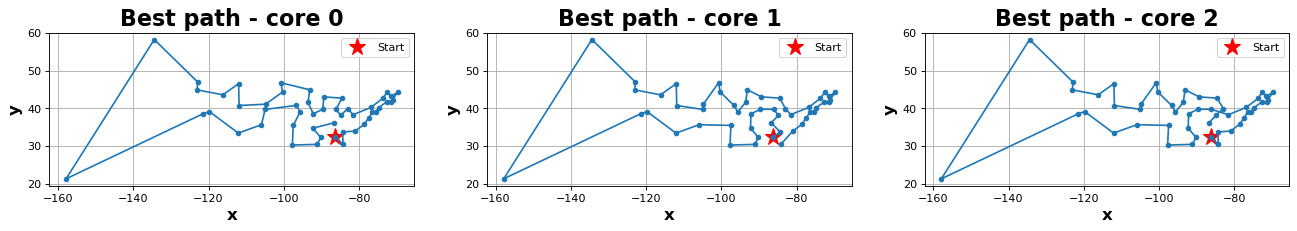

In [55]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


figure(figsize=(20, 10), dpi=80)

for i in range(0,3):
    plt.subplot(1,3,i+1)
    x,y = np.loadtxt("ex10/IndCont/cit/499citycoord"+str(i)+".out", usecols=(0,1), delimiter=' ', unpack='true')
    plt.plot(x[0],y[0], marker ="*", color = "r", markersize = 16, label = "Start", linestyle = "")
    plt.plot(x, y, marker = "o", markersize = 4, linestyle = "-")
    plt.ylabel('y', fontsize = 15, fontweight = "bold")
    plt.xlabel('x', fontsize = 15, fontweight = "bold")
    plt.grid(True)
    plt.title('Best path - core '+str(i), fontsize = 20, fontweight = "bold")
    plt.legend()

    plt.gca().set_aspect('equal', adjustable='box')

plt.show()

### Parallelo con migrazioni

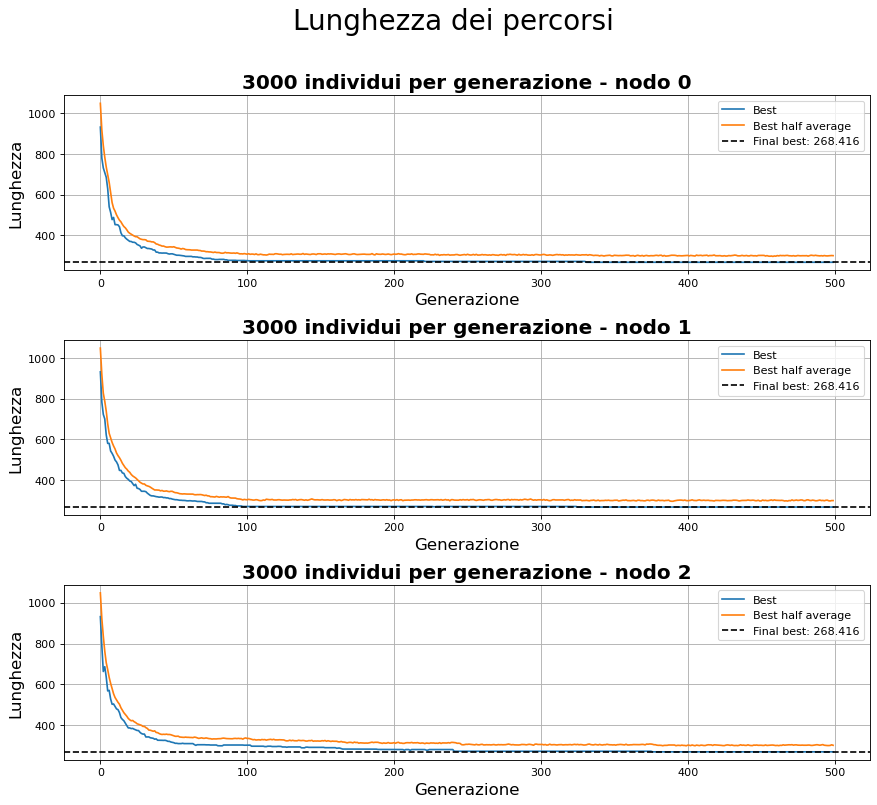

In [52]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

figure(figsize=(13, 11), dpi=80)
plt.suptitle("Lunghezza dei percorsi\n", fontsize = 25)

rank =["0", "1", "2"]

for i in range(0,3):
    # using rank[i] individuals per generation
    plt.subplot(3,1,i+1)
    gen,best = np.loadtxt("ex10/Migr/bestLen/BL"+rank[i]+".out", usecols=(0,1), delimiter=' ', unpack='true')
    plt.plot(gen, best, marker = "", label = "Best") 
    bestave = np.loadtxt("ex10/Migr/bestLen/BLAv"+rank[i]+".out", usecols=(1), delimiter=' ', unpack='true')
    plt.plot(gen, bestave, marker = "", label = "Best half average") 
    plt.ylabel('Lunghezza', fontsize =15)
    plt.xlabel('Generazione', fontsize =15)
    plt.grid(True)
    plt.title('3000 individui per generazione - nodo '+rank[i], fontsize = 18, fontweight = "bold")
    plt.axhline(y=best[499], color = "k", linestyle = "--", label = "Final best: "+str(best[499]))
    plt.legend()

plt.subplots_adjust(hspace=0.4)
plt.show()


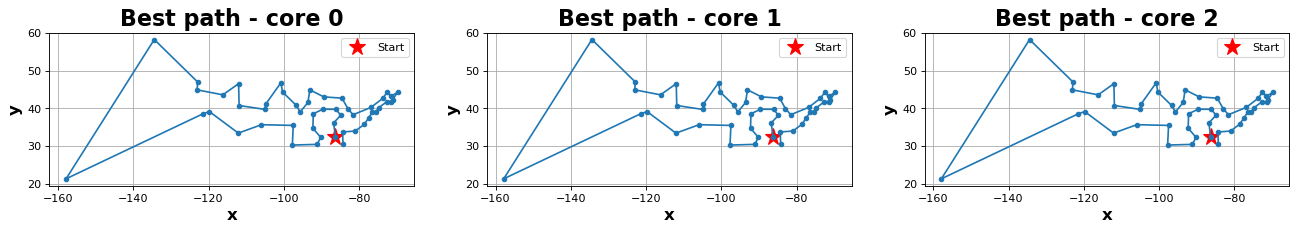

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


figure(figsize=(20,10), dpi=80)

for i in range(0,3):
    plt.subplot(1,3,i+1)
    x,y = np.loadtxt("ex10/Migr/cit/499citycoord"+str(i)+".out", usecols=(0,1), delimiter=' ', unpack='true')
    plt.plot(x[0],y[0], marker ="*", color = "r", markersize = 16, label = "Start", linestyle = "")
    plt.plot(x, y, marker = "o", markersize = 4, linestyle = "-")
    plt.ylabel('y', fontsize = 15, fontweight = "bold")
    plt.xlabel('x', fontsize = 15, fontweight = "bold")
    plt.grid(True)
    plt.title('Best path - core '+str(i), fontsize = 20, fontweight = "bold")
    plt.legend()

    plt.gca().set_aspect('equal', adjustable='box')

plt.show()

### Osservazioni

Calibrare l'algoritmo è un compito lungo e non semplice.  
Realizzare migrazioni permette di raffinare la soluzione solo una volta che la popolazione è mediamente molto buona, quindi non ha praticamente alcun effetto nella fase iniziale di convergenza e comunque non sempre permette di ottenere risultati significativamente migliori dell'esecuzione senza migrazioni. Ad ogni modo, questa pratica non rallenta di molto il codice, quindi complessivamente conviene usarla.

In generale osservo che la convergenza iniziale è in tutti i casi piuttosto rapida ($<100$ generazioni), mentre la ricerca della *soluzione vera* può richiedere più di $500$ passi (forse anche molti di più): in un problema reale può essere quindi importante stabilire una tolleranza sul risultato, raggiunta la quale si può interrompere la ricerca.